<a href="https://colab.research.google.com/github/AllanBottino/Series_Temporais_Python/blob/main/Modelo_Auto_Regressivo_(AR)_S%C3%A9ries_Temporais_Parte__7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Importando as Bibliotecas:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import warnings
warnings.filterwarnings("ignore")

# 2 - Carregando o dataset:

In [2]:
# Vamos carregar os dois arquivos:

#train=pd.read_csv("C:/Users/Allan/Documents/Projetos/store_item_demand_train.csv")
#test=pd.read_csv("C:/Users/Allan/Documents/Projetos/store_item_demand_test.csv")

from google.colab import files
uploaded = files.upload()

Saving store_item_demand_test.csv to store_item_demand_test.csv
Saving store_item_demand_train.csv to store_item_demand_train.csv


In [188]:
import io

train = pd.read_csv(io.BytesIO(uploaded['store_item_demand_train.csv']), parse_dates=['date'], index_col='date')

test = pd.read_csv(io.BytesIO(uploaded['store_item_demand_test.csv']), parse_dates=['date'], index_col='date')

# Junto os dois arquivos (train e test) em uma só coisa.
df = pd.concat([train, test])

# Crio uma cópia do dataframe original e uso a cópia, existem inúmeras vantagens de se usar desta maneira.
df1 = df.copy()

# Aqui eu selecionei para vermos apenas o item 14 da store 1.
df1= df1[df1['store']==1]
df1 = df1[df1['item']==1]

# Aqui vamos selecionar essa range de data e reamostrar por semana e pegar somente as somas semanais.
df1 = df1['2013-01-01':'2017-12-30'].resample('W').sum()


# Deleto algumas colunas:
df1.drop(["id", "store", "item"], axis =1, inplace = True)

# Uso o print pois eu acho que com print fica melhor de se ver as informações.
print(df1.head())

            sales
date             
2013-01-06   73.0
2013-01-13   66.0
2013-01-20   80.0
2013-01-27   70.0
2013-02-03   86.0


# 3 – Naive:
Antes de entrar no AR, vou usar o modelo Naive, pois entendendo o Naive o AR vai mais fácil e vocês já vão ver o porquê disso.

# Modelo Naive
O modelo Naive é um preditor de série temporal “básico/simples/inocente”.

A ideia do modelo é a de que o valor previsto para o período atual t seja igual ao valor do período t−1, segue o exemplo:


In [189]:
df1['naive_prediction'] = df1.sales.shift(1)
print(df1.head())

            sales  naive_prediction
date                               
2013-01-06   73.0               NaN
2013-01-13   66.0              73.0
2013-01-20   80.0              66.0
2013-01-27   70.0              80.0
2013-02-03   86.0              70.0


Acho que essa é uma daquelas vezes que vendo dá para entender melhor do que com uma explicação, não é? 

O modelo Naive pega o tempo passado e o joga para frente, mas como eu disse ele é um modelo de predição “básico/simples/inocente”, e vocês verão mais abaixo a diferença entre o Naive e o AR.




Plotando as duas séries, é possível observar o comportamento do modelo.



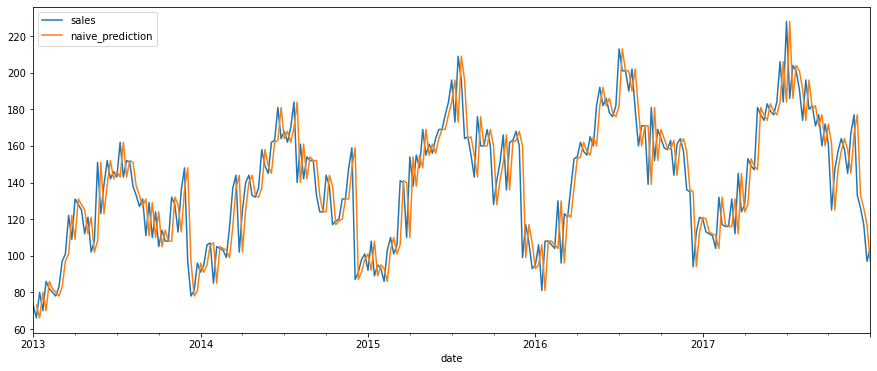

In [190]:
df1.plot(figsize=(15, 6))

# 4 - Avaliando o modelo:

A validação serve para saber a diferença entre o valor previsto e o valor real, aqui nós vamos usar o erro médio quadrático, ou seja, vamos pegar o valor que já tínhamos, menos o valor previsto e elevar ao quadrado.

Mas saibam não existe só essa métrica para avaliar o desempenho do modelo, existem muitas outras como MAE (Média absoluta do erro), RMSR (Raiz média do erro quadrático) e a que vamos usar o MSR (Média do erro quadrático).
Caso vocês tenham dificuldade em entender esses conceitos acima, aqui está um excelente vídeo que nos poupará muitas lágrimas:

https://www.youtube.com/watch?v=_pJX2SFoFtY


In [191]:
((df1.sales - df1.naive_prediction) ** 2).mean()

312.7346153846154

Como podemos ver o erro médio quadrático é de 323.61... 

O modelo Naive é utilizado como referência para modelos mais sofisticados. A idéia é que modelos de previsão possuam erro médio quadrático menor que o modelo Naive. Caso contrário, temos um modelo extremamente ineficaz.

Abaixo começaremos a ver o AR e poderemos comparar o erro do Modelo de Naive com o erro do Modelo de AR.


# 5 - Modelo AutoRegressivo (AR)

Se vocês já viram esse vídeo aqui:

https://www.youtube.com/watch?v=J9HuFIYcFWU

Já devem ter uma ideia do que é um modelo auto regressivo.
Agora, alguns detalhes que eu gostaria de ter visto logo de cara antes de ler milhões de artigos e pdfs:

Dentro do AR existe:

AR(1) = O 1 vem do números de defasagens/lags/atrasos, que no nesse caso é 1.

AR(2) = O 2 vem também do número de defasagem/lag/atrasos, que no nesse caso é 2.

AR(p) = O p vem do número que defasages/lags/atrasos que nós decidimos, por exemplo, poderia ser um p = de 30, ou 60, o valor que você decidir.

Sei que já devem ter entendido, mas vou enfatizar novamente, essas defasagens/lags/atrasos, é aquele “pulo” que os valores dão, que gerou o nan no naive, então damos um “pulo” e usamos os valores após os “pulos”. 
Continuemos:


In [192]:
# Aqui eu executei novamente o "Carregando Dataset" para limpar o df e tirar o Naive daqui. 
df1['x1'] = df1.sales.shift(1)
df1.dropna(axis=0, inplace=True)
print(df1.head())

            sales  naive_prediction    x1
date                                     
2013-01-13   66.0              73.0  73.0
2013-01-20   80.0              66.0  66.0
2013-01-27   70.0              80.0  80.0
2013-02-03   86.0              70.0  70.0
2013-02-10   82.0              86.0  86.0


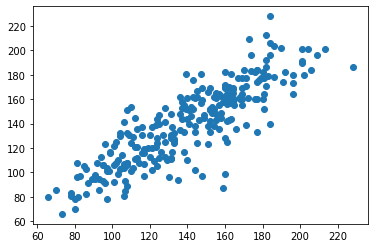

In [193]:
plt.scatter(df1.x1, df1.sales)

Essa parte a baixo eu vou destrinchar e depois eu faço um código mostrando tudo de uma só vez:

In [194]:
x = df1.x1.values.reshape(-1,1)
#x

Acima nós pegamos atribuimos ao "x" os valores do x1 que por sua vez estão com o lag em 1 (shifit(1)).

O comando "values" cria uma lista somente com os valores das vendas (sales+shift).

O comando reshape muda a posição dos dados por exemplo (faça o teste) se você usar reshape(3,2) a posição do resultado será um, se você usar (1,1) será outro, mas aqui para funcionar na regressão linear que vamos fazer precisa ser (-1,1)

Deem uma olhada aqui:
https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape




In [195]:
y = df1.sales.values
#y

Aqui dentro da variável y colocamos o valor sales e usamos o values para transformar os dados da forma como vocês veem.

Agora, por que usamos o reshape no x e não no y? Pois remodelamos(reshape) o x pois ele é o alvo (target). Nossa previsão é uma AR(1) ou seja a coluna x é a coluna que nós usamos o shift(1) e criamos a defasagem/lag/atraso em 1.
Por isso vamos prever o x.


In [196]:
model = LinearRegression().fit(x, y)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Como já disse lá encima, o modelo de regressão linear basicamente encontra o melhor valor para o intercepto e a inclinação do intercepto(ângulo), o que resulta em uma linha que melhor se ajusta aos dados. Mais abaixo eu usarei alguns comandos para vermos o intercepto e o seu ângulo.
Pois bem, acabado de relembrar o que a regressão linear faz, usamos o comando:
“LinearRegression().fit(x, y)”
Usamos a função de regressão linear (o algoritmo) (LinearRegression) depois usamos o comando “.fit” para treinar, descobrir qual é a melhor linha reta que se ajusta a esse modelo tendo em vista que usamos uma defasage/lag/atraso de 1 (shifit(1) sobre o x1).


In [197]:
predictions = model.predict(x)
#predictions

Pronto, depois de treinado, executamos o comando “.predict” sobre o x (target) e o que vocês veem é o resultado da predição, não ficou bonito nem muito claro, mas mais abaixo eu vou deixar isso de uma forma mais clara de se entender, por hora só me acompanhem.

In [198]:
from sklearn.linear_model import LinearRegression

x = df1.x1.values.reshape(-1,1)
y = df1.sales.values

model = LinearRegression().fit(x, y)

predictions = model.predict(x)

#predictions

# 6 - Validando/Avaliando o Modelo o AR(1)

Aqui eu também vou destrichar o código:

In [199]:
errors = (y - predictions)
#errors

Olhem só, dentro da variável y estão os dados reais/originais, e então nós pegamos os dados originais menos a nossa predição, nós temos os erros.

In [200]:
errors = (y - predictions) ** 2
#errors

Agora, se nós pegarmos os nossos erros e elevarmos ao quadrado? Eis que surge o erro ao quadrado!

In [201]:
errors = (y - predictions) ** 2
errors.mean()

288.0116258985935

E agora, se pegarmos tudo o que fizemos antes e fizermos a média?
Temos então o erro do quadrado médio! Ou MSE (Mean square error)!


In [202]:
from sklearn.linear_model import LinearRegression

x = df1.x1.values.reshape(-1,1)
y = df1.sales.values

model = LinearRegression().fit(x, y)

predictions = model.predict(x)

errors = (y - predictions) ** 2
errors.mean()

288.0116258985935

Se compararmos com o valor do erro do modelo Naive: 323.61, o nosso de erro usando a regressão linear com defasagem em 1 é de: 288.01.
Um pouco melhor o nosso resultado não?


Text(0, 0.5, 'sales')

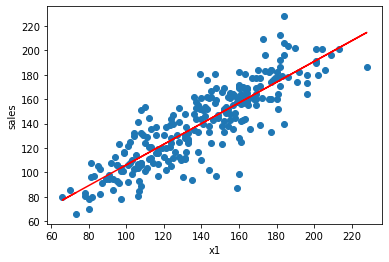

In [203]:
plt.scatter(x, y)
plt.plot(x, model.predict(x.reshape(-1, 1)), color='red')
plt.xlabel('x1')
plt.ylabel('sales')

Para visualizar o modelo na forma de uma série temporal criaremos uma nova coluna no DataFrame df1 chamada ar_1.

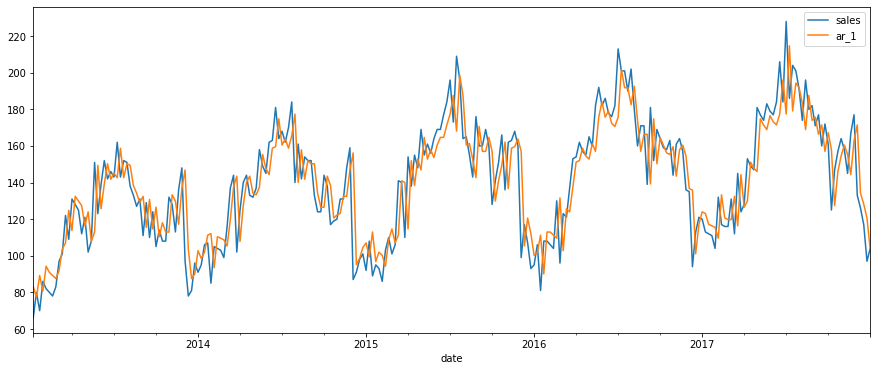

In [204]:
df1['ar_1'] = model.predict(x.reshape(-1, 1))

df1[['sales', 'ar_1']].plot(figsize=(15, 6))

In [205]:
print(df1.head())

            sales  naive_prediction    x1       ar_1
date                                                
2013-01-13   66.0              73.0  73.0  83.273554
2013-01-20   80.0              66.0  66.0  77.338058
2013-01-27   70.0              80.0  80.0  89.209049
2013-02-03   86.0              70.0  70.0  80.729770
2013-02-10   82.0              86.0  86.0  94.296616


Como podem ver aí está a nossa previsão na coluna “ar_1”. Viva nós, fizemos uma previsão usando regressão linear, mas vamos continuar mais um pouco.

In [206]:
print(model.intercept_)

21.374817794582484


É da posição/valor 21.37 que o intercepto saí do eixo Y.

In [207]:
print(model.coef_)

[0.84792789]


E 0.847... é o ângulo do intercepto em relação ao eixo X.


Acho que para um artigo está bom, abraços.

